In [1]:
using LinearAlgebra #線形代数パッケージ
using Combinatorics #組み合わせ順列を扱うパッケージ
using SparseArrays #疎行列を扱うパッケージ
using Arpack #大規模な固有値問題のためのパッケージ

## **Jordan-Wigner 変換**

In [26]:
"""
    jordan_wigner(num_modes::Integer, index::Integer)

define a fermionic anihilation operator with index `index` among `num_modes` modes using the Jordan-Wigner transformation.
"""
function jordan_wigner(num_modes::Integer, index::Integer)
    σ⁰ = [
        1.0 0.0
        0.0 1.0
    ] |> sparse;
    σ³ = [
        1.0 0.0
        0.0 -1.0
    ] |> sparse;
    σ⁻ = [
        0.0 0.0
        1.0 0.0
    ] |> sparse;
    pauli_strings = [-σ³ for i in 1:index-1]
    append!(pauli_strings, [σ⁻]) # ! は破壊的処理(pythonで言うところの in_place = True) を意味する
    append!(pauli_strings, [σ⁰ for i in index+1:num_modes])
    return kron(pauli_strings...)
end;

In [62]:
@doc jordan_wigner

```
jordan_wigner(num_modes::Integer, index::Integer)
```

define a fermionic anihilation operator with index `index` among `num_modes` modes using the Jordan-Wigner transformation.


In [69]:
"""
    get_index_from_nlist(nlist::Vector{Int}, num_sites::Int)

get an array of integers such that when they are represented in terms of binary, the number of zeros corresponds to the pair of integers given by `nlist`. The number of digis in the binary representation is `length(nlist)*num_sites`.

# Examples
```jldoctest
julia> nlist = [2, 1];

julia> num_sites = 3;

julia> 9-element Vector{Int64}:
7
13
37
19
25
49
22
28
52
```
"""
function get_index_from_nlist(nlist::Vector{Int}, num_sites::Int)::Vector{Int}
    l = length(nlist)
    num_digits = l*num_sites
    base = reverse([2^i for i in 0:num_digits-1])
    binary_array = Array{Any}(nothing, l)
    for s in 1:l
        seed_vector = ones(Integer, num_sites)
        for i in 1:nlist[s]
            seed_vector[i] = 0
        end
        binary_array[s] = unique(permutations(seed_vector)) 
    end
    return_array = Int[]
    for n_set in collect(Iterators.product(binary_array...))
        h = hcat(n_set...)'
        h = collect(Base.Flatten(h))
        append!(return_array, dot(h, base))
    end
    return return_array
end;

## **1次元鎖上の Fermi-Hubbard 模型**

In [75]:
"""
    fermi_hubbard_model(num_sites::Integer, t::Number, onsite_interaction::Real; kwargs...)

returns the Hamiltonian of the Fermi-Hubbard model on a one-dimensional chain.

# Arguments
- `num_sites::Integer`: the number of sites
- `t::Number`: hopping parameter
- `onsite_interaction::Real`: parameter for the on-site interaction
- `boundary_condition::String="open"`: boundary condition
- `particle_num:Union{Integer, Nothing}=nothing`: specify the number of particle. If it is nothing, the function returns the Hamiltonian in the full Hilbert space
- `nup::Union{Integer, Nothing}=nothing`: the number of up spins
- `ndown::Union{Integer, Nothing}=nothing` the number of down spins
"""
function fermi_hubbard_model(num_sites::Integer, t::Number, onsite_interaction::Real; boundary_condition::String="open", particle_num::Union{Integer, Nothing}=nothing, nup::Union{Integer, Nothing}=nothing, ndown::Union{Integer, Nothing}=nothing)
    num_modes = 2*num_sites # the number of spin degrees of freedom times the number of sites
    dim = 2^num_modes # the dimension of the Hilbert space
    ham = spzeros(dim, dim) # initialize the Hamiltonian 
    cop_vec = [JordanWigner(num_modes, i) for i in 1:num_modes] # define the fermionic anihilation operators
    cdg_vec = adjoint.(cop_vec) # define the fermionic creation operators
    nop_vec = [cdg_vec[i]*cop_vec[i] for i in 1:num_modes] # define the number operators
    for i in 1:num_sites-1
        add_ham = t*(cdg_vec[2*i-1]*cop_vec[2*i+1] + cdg_vec[2*i]*cop_vec[2*i+2]) # hopping term
        add_ham += adjoint(add_ham) # hopping term
        add_ham += onsite_interaction*nop_vec[2*i-1]*nop_vec[2*i] # interaction term
        ham += add_ham
    end
    ham += onsite_interaction*nop_vec[2*num_sites-1]*nop_vec[2*num_sites]

    # boundary condition
    if boundary_condition == "periodic" && num_sites > 2
        add_ham = t*(cdg_vec[2*num_sites-1]*cop_vec[1] + cdg_vec[2*num_sites]*cop_vec[2])
        add_ham += adjoint(add_ham)
        ham += add_ham
    end

    if particle_num == nothing 
        return ham
    else 
        if nup == nothing && ndown == nothing 
            indices = get_index_from_nlist([particle_num], num_modes) .+ 1
            return ham[indices, indices]
        elseif  typeof(nup) <: Integer && typeof(ndown) <: Integer 
            if nup + ndown == particle_num
                indices = get_index_from_nlist([nup, ndown], num_sites) .+ 1
                return ham[indices, indices]
            else
                println("$(nup) + $(ndown) is not $(particle_num).")
            end
        else
            println("nup and ndown must be Integer or Nothing, simulataneously.")
        end
    end
end;

"""
    lowest_energy(hamiltonian; kwargs...)
get the lowest energy of `hamiltonian`.

# Arguments
- `hamiltonian`: target hamiltonian
- `sparse::Bool=true`: if false, it converts `hamilaonian` to a dense matrix
"""
function lowest_energy(hamiltonian; sparse=true)::Real
    if sparse == true
        e, _ = eigs(hamiltonian, nev=1, which=:SR)
        return e[1]
    elseif sparse == false
        ham = Hermitian(Matrix(hamiltonian))
        e, _ = eigen(ham, 1:1)
        return e[1]
    end
end;

## **対角化**

In [80]:
num_sites = 6
t = -1.0
u = 1.0
@time fhm_ham = fermi_hubbard_model(num_sites, t, u, particle_num=6, nup=3, ndown=3)
@time gs_energy = lowest_energy(fhm_ham, sparse=true)
println("The ground state energy is $(gs_energy).")

  0.010057 seconds (16.20 k allocations: 12.250 MiB)
  0.008998 seconds (462 allocations: 105.672 KiB)
The ground state energy is -5.628893198968257.


In [81]:
"""
    u_dependence(num_sites::Integer, t::Number, umin::Real, umax::Real, length::Integer; kwargs...)
calculate the ground-state energies for given parameters

# Arguments
- `num_sites::Integer`: the number of sites 
- `t::Number`: hopping parameter
- `umin::Real`: the minimum value of the interaction parameters
- `umax::Real`: the maximum value of the interaction parameters
- `length::Integer`: the number of points
- `boundary_condition::String="open"`: boundary condition 
- `particle_num::Union{Integer, Nothing}=nothing`: the number of particles
- `nup::Union{Integer, Nothing}=nothing`: the number of up spins
- `ndown::Union{Integer, Nothing}=nothing` the number of down spins
"""
function u_dependence(num_sites::Integer, t::Number, umin::Real, umax::Real, length::Integer; boundary_condition::String="open", particle_num::Union{Integer, Nothing}=nothing, nup::Union{Integer, Nothing}=nothing, ndown::Union{Integer, Nothing}=nothing)::Vector{Real}
    energies = Real[]
    for onsite_interaction in range(umin, umax, length=length)
        fhm_ham = fermi_hubbard_model(
            num_sites,
            t,
            onsite_interaction,
            boundary_condition=boundary_condition,
            particle_num=particle_num,
            nup=nup,
            ndown=ndown
        )
        e = lowest_energy(fhm_ham)
        append!(energies, e)
    end
    return energies
end;

In [82]:
using Plots

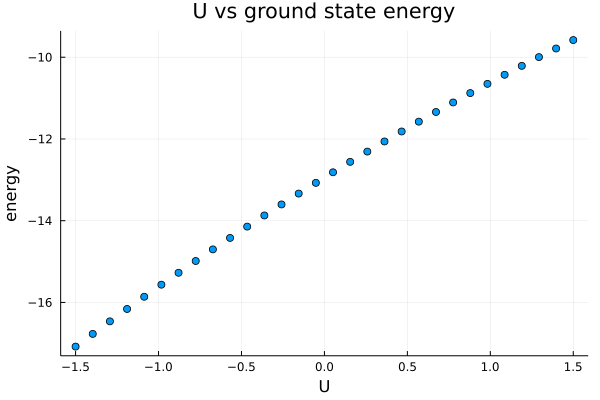

In [92]:
num_size = 10
particle_num = 10
nup = 5
ndown = 5
t = -1.0
umin = -1.5
umax = 1.5
Δu = 0.1
l = Int(floor((umax - umin)/Δu))
u_list = collect(range(umin, umax, length=l))
energies = u_dependence(
    num_size,
    t,
    umin,
    umax,
    l,
    boundary_condition="periodic",
    particle_num=particle_num,
    nup=nup,
    ndown=ndown
)
energies = round.(energies, digits=8)
scatter(
    u_list,
    energies,
    title="U vs ground state energy",
    xlabel="U", 
    ylabel="energy",
    label=""
)|> display